* **Aim** : Running all 4 codebases on 1 of the recordings from Box, using dask<br />
* **Recording** : 34_KS_Recording4-LR_2165-2465_CT<br />
* **Codebases** <br />
Codebase 1: yinruiqing https://github.com/yinruiqing/pyannote-whisper/ <br />
Codebase 2: speechbox https://github.com/huggingface/speechbox/ <br />
Codebase 3: ashraf https://github.com/MahmoudAshraf97/whisper-diarization <br />
Codebase 4: whisperx https://github.com/m-bain/whisperX <br />

In [ ]:
import pandas as pd
from pydub import AudioSegment
import os
import dask
import socket
from dask_jobqueue import SLURMCluster
from  distributed import Client
import subprocess
!module load openmind/ffmpeg/20160310 

: 

In [9]:
# Load the WAV file
audio = AudioSegment.from_wav("rawAudioFiles/34_KS_Recording4-LR_2165-2465_CT.wav")
directory_path = os.path.join("chunks_"+"34_KS_Recording4-LR_2165-2465_CT")
os.makedirs(directory_path, exist_ok=True)
# Length of one minute in milliseconds
one_minute = 60 * 1000

# Split and save each 1-minute segment
for i in range(5):
    start_time = i * one_minute
    end_time = (i + 1) * one_minute if i < 4 else len(audio)
    segment = audio[start_time:end_time]
    name_of_file = f"minute_{i + 1}.wav"
    path_to_file = os.path.join(directory_path, name_of_file)
    segment.export(path_to_file, format="wav")

print("Audio split into 1-minute segments successfully!")


Audio split into 1-minute segments successfully!


In [55]:
cluster = SLURMCluster(cores=8,
                       processes=2,
                       memory="16GB",
                       account="cpl",
                       walltime="01:00:00",
                       queue="normal",
                       job_script_prologue  =[
                        'source /etc/profile.d/modules.sh' ,
                        'module load openmind8/anaconda/3-2023.09-0',
                        'module load openmind8/cuda/12.1',                 
                        'module load openmind8/cudnn/8.8.1-cuda12'  ,
                        'module load openmind/gcc/11.1.0',
                        'module load openmind/ffmpeg/20160310' , 
                        'source ~/.bashrc',
                        'conda activate whisperx'
                                              ],
                       job_extra=['--gres=gpu:QUADRORTX6000:1'] 
                       )
cluster.scale(5)
client = Client(cluster)

# 32 gb of RAM, 16 CPUs, 1 GPU



/home/arjunp/.local/lib/python3.11/site-packages/dask_jobqueue/core.py:266: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41739 instead
  warnings.warn(


In [3]:
!squeue -u arjunp

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          37466907    normal     bash   arjunp  R      23:46      1 node081


In [71]:
!scancel 37451543 37451544 37451545

In [4]:
def run_cb1_script(audiopath):
     
    command = ['python', 'yinruiqing_trial.py', audiopath]  
    
    result = subprocess.run(command, capture_output=True, text=True)
     
    print("STDOUT:", result.stdout)
    print("STDERR:", result.stderr)
    return result

def run_cb2_script(audiopath):
     
    command = ['python', 'speechbox_trial.py', audiopath]  
    
    result = subprocess.run(command, capture_output=True, text=True)
     
    print("STDOUT:", result.stdout)
    print("STDERR:", result.stderr)
    return result

def run_cb3_script(audiopath):
     
    command = ['python', '/om/user/arjunp/ashraf_repo/whisper-diarization/diarize.py','-a',audiopath] 
    srtpath = audiopath[:-4] +".srt"
    command2 = ['python', '/om/user/arjunp/process_ashraf_output.py', srtpath]  
    result = subprocess.run(command, capture_output=True, text=True)
    result2 = subprocess.run(command2, capture_output=True, text=True)
     
    print("STDOUT:", result.stdout)
    print("STDERR:", result.stderr)
    return result

def run_whisperx(audiopath):
     
    command = ['python', 'whisperx_demo.py',audiopath]  
    
    result = subprocess.run(command, capture_output=True, text=True)
     
    print("STDOUT:", result.stdout)
    print("STDERR:", result.stderr)
    return result



In [58]:
result_list = []
for filename in os.listdir('chunks_34_KS_Recording4-LR_2165-2465_CT'):
    audiopath = os.path.join('chunks_34_KS_Recording4-LR_2165-2465_CT', filename)
    future  = client.submit(run_whisperx,audiopath)  
    result  = future.result()
    result_list.append(result)

In [31]:
print(result.stderr)

Traceback (most recent call last):
  File "/weka/scratch/weka/cpl/arjunp/whisperx_demo.py", line 1, in <module>
    import whisperx
  File "/home/arjunp/.conda/envs/whisperx/lib/python3.10/site-packages/whisperx/__init__.py", line 1, in <module>
    from .transcribe import load_model
  File "/home/arjunp/.conda/envs/whisperx/lib/python3.10/site-packages/whisperx/transcribe.py", line 10, in <module>
    from .asr import load_model
  File "/home/arjunp/.conda/envs/whisperx/lib/python3.10/site-packages/whisperx/asr.py", line 13, in <module>
    from .vad import load_vad_model, merge_chunks
  File "/home/arjunp/.conda/envs/whisperx/lib/python3.10/site-packages/whisperx/vad.py", line 9, in <module>
    from pyannote.audio import Model
  File "/home/arjunp/.conda/envs/whisperx/lib/python3.10/site-packages/pyannote/audio/__init__.py", line 29, in <module>
    from .core.inference import Inference
  File "/home/arjunp/.conda/envs/whisperx/lib/python3.10/site-packages/pyannote/audio/core/infere

In [27]:
def codebase1Run():
    cluster = SLURMCluster(cores=4,
                       processes=2,
                       memory="16GB",
                       account="cpl",
                       walltime="01:00:00",
                       queue="normal",
                       job_script_prologue  =[
                        'source /etc/profile.d/modules.sh' ,
                        'module load openmind8/anaconda/3-2023.09-0',
                        'module load openmind/gcc/11.1.0',
                        'module load openmind/ffmpeg/20160310' , 
                        'source ~/.bashrc',
                        'export MKL_THREADING_LAYER=GNU',
                        'conda activate torch_gpu'
                                              ],
                       job_extra=['--gres=gpu:QUADRORTX6000:1'] 
                       )
    cluster.scale(5)
    client = Client(cluster)
    result_list = []
    for filename in os.listdir('chunks_34_KS_Recording4-LR_2165-2465_CT'):
        audiopath = os.path.join('chunks_34_KS_Recording4-LR_2165-2465_CT', filename)
        future  = client.submit(run_cb1_script,audiopath)  
        result  = future.result()
        result_list.append(result)
    cluster.close()
    client.close() #change this order
    return result_list

In [5]:
def codebase2Run():
    cluster = SLURMCluster(cores=4,
                       processes=2,
                       memory="16GB",
                       account="cpl",
                       walltime="01:00:00",
                       queue="normal",
                       job_script_prologue  =[
                        'source /etc/profile.d/modules.sh' ,
                        'module load openmind8/anaconda/3-2023.09-0',
                        'module load openmind/gcc/11.1.0',
                        'module load openmind/ffmpeg/20160310' , 
                        'source ~/.bashrc',
                        'export MKL_THREADING_LAYER=GNU',
                        'conda activate torch_gpu'
                                              ],
                       job_extra=['--gres=gpu:QUADRORTX6000:1'] 
                       )
    cluster.scale(5)
    client = Client(cluster)
    result_list = []
    for filename in os.listdir('chunks_34_KS_Recording4-LR_2165-2465_CT'):
        if filename[-3:]!='wav':
            continue
        if filename!=  'minute_5.wav':
            continue
        audiopath = os.path.join('chunks_34_KS_Recording4-LR_2165-2465_CT', filename)
        future  = client.submit(run_cb2_script,audiopath)  
        result  = future.result()
        result_list.append(result)
    return result_list

In [25]:
def codebase3Run():
    cluster = SLURMCluster(cores=4,
                       processes=2,
                       memory="16GB",
                       account="cpl",
                       walltime="01:00:00",
                       queue="normal",
                       job_script_prologue  =[
                        'source /etc/profile.d/modules.sh' ,
                        'module load openmind8/anaconda/3-2023.09-0',
                        'module load openmind/gcc/11.1.0',
                        'module load openmind/ffmpeg/20160310' , 'source ~/.bashrc',
                        'conda activate codebase3',
                        'cd /om/user/arjunp/ashraf_repo/whisper-diarization'
                                              ],
                       job_extra=['--gres=gpu:QUADRORTX6000:1'] 
                       )
    cluster.scale(5)
    client = Client(cluster)
    result_list = []
    main_directory = os.path.join('/om/user/arjunp','chunks_34_KS_Recording4-LR_2165-2465_CT')
    for filename in os.listdir(main_directory):
        audiopath = os.path.join(main_directory, filename)
        future  = client.submit(run_cb3_script,audiopath)  
        result  = future.result()
        result_list.append(result)
    client.close()
    return result_list

In [7]:
def codebase4Run():
    cluster = SLURMCluster(cores=4,
                       processes=2,
                       memory="16GB",
                       account="cpl",
                       walltime="01:00:00",
                       queue="normal",
                       job_script_prologue  =[
                        'source /etc/profile.d/modules.sh' ,
                        'module load openmind8/anaconda/3-2023.09-0',
                        'module load openmind8/cuda/12.1',                 
                        'module load openmind8/cudnn/8.8.1-cuda12'  ,
                        'module load openmind/gcc/11.1.0',
                        'module load openmind/ffmpeg/20160310' , 
                        'source ~/.bashrc',
                        'conda activate whisperx'
                                              ],
                       job_extra=['--gres=gpu:QUADRORTX6000:1'] 
                       )
    cluster.scale(5)
    client= Client(cluster)
    
    result_list = []
    for filename in os.listdir('chunks_34_KS_Recording4-LR_2165-2465_CT'):
        audiopath = os.path.join('chunks_34_KS_Recording4-LR_2165-2465_CT', filename)
        future  = client.submit(run_whisperx,audiopath)  
        result  = future.result()
        result_list.append(result)
    return result_list

In [28]:
cb1res = codebase1Run()

/home/arjunp/.local/lib/python3.11/site-packages/dask_jobqueue/core.py:266: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35445 instead
  warnings.warn(
/home/arjunp/.local/lib/python3.11/site-packages/dask_jobqueue/core.py:266: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will

In [32]:
cb1res[0].stderr

'Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.3.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../../../home/arjunp/.cache/torch/pyannote/models--pyannote--segmentation/snapshots/c4c8ceafcbb3a7a280c2d357aee9fbc9b0be7f9b/pytorch_model.bin`\n'

In [10]:
cb2res = codebase2Run()

/home/arjunp/.local/lib/python3.11/site-packages/dask_jobqueue/core.py:266: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44895 instead
  warnings.warn(


In [26]:
cb3res = codebase3Run()

/home/arjunp/.local/lib/python3.11/site-packages/dask_jobqueue/core.py:266: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35195 instead
  warnings.warn(


In [13]:
print(cb2res[0].stdout)

Model was trained with pyannote.audio 0.0.1, yours is 3.3.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.3.1+cu118. Bad things might happen unless you revert torch to 1.x.
Running CB2: speechbox
[2.0 4.0 6.0 8.0 10.0 12.0 14.0 16.0 18.0 20.0 22.0 24.0 27.0 36.36 46.0
 47.0 50.0 None] 58.992218750000006



In [23]:
print(cb3res[0].stderr)

Selected model is a bag of 1 models. You will see that many progress bars per track.
Separated tracks will be stored in /weka/scratch/weka/cpl/arjunp/ashraf_repo/whisper-diarization/temp_outputs/htdemucs
Separating track /om/user/arjunp/chunks_34_KS_Recording4-LR_2165-2465_CT/minute_2.wav
GPU Name: Quadro RTX 6000
CUDA Compute Capability: (7, 5)
Your GPU supports efficient float16 computation.
Model was trained with pyannote.audio 0.0.1, yours is 3.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.1.2+cu121. Bad things might happen unless you revert torch to 1.x.
[NeMo I 2024-07-28 22:45:26 msdd_models:1092] Loading pretrained diar_msdd_telephonic model from NGC
[NeMo I 2024-07-28 22:45:26 cloud:58] Found existing object /home/arjunp/.cache/torch/NeMo/NeMo_1.20.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo.
[NeMo I 2024-07-28 22:45:26 cloud:64] Re-using file from: /home/arjunp/

## Initial analysis with gold standard transcript

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

def return_counts(corpus):
    vectorizer = CountVectorizer(token_pattern=r'(?u)\b\w+\b')
    X = vectorizer.fit_transform(corpus)
    vocab = vectorizer.vocabulary_
    word_freq = X.toarray().sum(axis=0)
    word_freq_dict = {word: word_freq[idx] for word, idx in vocab.items()}
    return word_freq_dict

In [19]:
def scrapeCBoutput(codebasename):
    cb_alltext = []
    directory = 'trial_audio_outputs'
    for i in range (1,6):
        if codebasename == 'yinruiqing':
            filename = f'output_yinruiqing_minute_{i}.wav.csv'
        elif codebasename == 'ashraf':
            filename = f'output_ashraf_minute_{i}.srt.csv'
        else:
            filename = f'chunks_34_KS_Recording4-LR_2165-2465_CT_minute_{i}.csv'
        filepath = os.path.join(directory, filename)
        df = pd.read_csv(filepath)
        cb_alltext.append(df['text'].to_list())
        
    flattened_list = sum(cb_alltext, [])
    return flattened_list

In [21]:
cb1_alltext = scrapeCBoutput('yinruiqing')
cb3_alltext = scrapeCBoutput('ashraf')
cb4_alltext = scrapeCBoutput('whisperx')

In [16]:
df = pd.read_csv('/om/user/arjunp/chunks_34_KS_Recording4-LR_2165-2465_CT_minute_5.csv')

In [18]:
return_counts(df['text'])

{'how': 1,
 'old': 1,
 'are': 1,
 'you': 8,
 'no': 2,
 'they': 2,
 'didn': 3,
 't': 3,
 'say': 1,
 'happy': 2,
 'birthday': 2,
 'sing': 1,
 'oh': 3,
 'nope': 1,
 'i': 3,
 'decorated': 2,
 'them': 1,
 'put': 1,
 'some': 1,
 'ice': 1,
 'on': 1,
 'it': 3,
 'and': 2,
 'then': 1,
 'what': 1,
 'did': 3,
 'decorate': 2,
 'my': 1,
 'cupcake': 3,
 'your': 2,
 'own': 1,
 'yep': 2,
 'sure': 1,
 'mmm': 1,
 'make': 1,
 'good': 1,
 'yes': 2,
 'eat': 1,
 'the': 4,
 'whole': 1,
 'just': 1,
 'ate': 2,
 'icing': 1,
 'candy': 1,
 'all': 1,
 'of': 1,
 'decorations': 1,
 'huh': 1,
 'who': 1,
 'else': 1,
 'came': 1,
 'to': 1,
 'party': 1}

In [25]:
import re
def parse_script(content):
    lines = content.strip().split('\n')
    data = []
    for line in lines:
        match = re.match(r"(.+?): (.+)", line)
        if match:
            speaker = match.group(1).strip()
            dialogue = match.group(2).strip()
            data.append([speaker, dialogue])
    return data

with open("/om/user/arjunp/34_KS_Recording4-LR_2165-2465_CT-IC.txt", "r") as file:
    script_content = file.read()

# Parse and create the DataFrame as before
parsed_data = parse_script(script_content)
gold_standard_df = pd.DataFrame(parsed_data, columns=["speaker", "text"])


In [27]:
gold_standard_counts = return_counts(gold_standard_df['text'])
cb1_counts = return_counts(cb1_alltext)
cb3_counts = return_counts(cb3_alltext)
cb4_counts = return_counts(cb4_alltext)

In [37]:
gold_df = pd.DataFrame(list(gold_standard_counts.items()) , columns=["token", "count"])
cb1_df = pd.DataFrame(list(cb1_counts.items()) , columns=["token", "count"])
cb3_df = pd.DataFrame(list(cb3_counts.items()) , columns=["token", "count"])
cb4_df = pd.DataFrame(list(cb4_counts.items()) , columns=["token", "count"])

In [51]:
merge_step1 = pd.merge(gold_df, cb1_df, on='token', how='outer',suffixes=('_gold', '_cb1'))
merge_step2 = pd.merge(merge_step1, cb3_df, on='token', how='outer',suffixes=(None, '_cb3'))
merge_step3 = pd.merge(merge_step2, cb4_df, on='token', how='outer',suffixes=(None, '_cb4'))
merge_step3.columns = ['token', 'count_gold', 'count_cb1', 'count_cb3', 'count_cb4']
merge_step3.fillna(0, inplace=True)

In [62]:
merge_step3['count_cb1_residuals'] = merge_step3['count_gold'] - merge_step3['count_cb1']
merge_step3['count_cb3_residuals'] = merge_step3['count_gold'] - merge_step3['count_cb3']
merge_step3['count_cb4_residuals'] = merge_step3['count_gold'] - merge_step3['count_cb4']
merge_step3['status_cb1'] = merge_step3['count_cb1_residuals'].apply(lambda x: 'undercount' if x > 0 else ('overcount' if x < 0 else 'exact'))
merge_step3['status_cb3'] = merge_step3['count_cb3_residuals'].apply(lambda x: 'undercount' if x > 0 else ('overcount' if x < 0 else 'exact'))
merge_step3['status_cb4'] = merge_step3['count_cb4_residuals'].apply(lambda x: 'undercount' if x > 0 else ('overcount' if x < 0 else 'exact'))


In [82]:
merge_step3.to_csv('token_count_residuals.csv', index=False)

/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated a

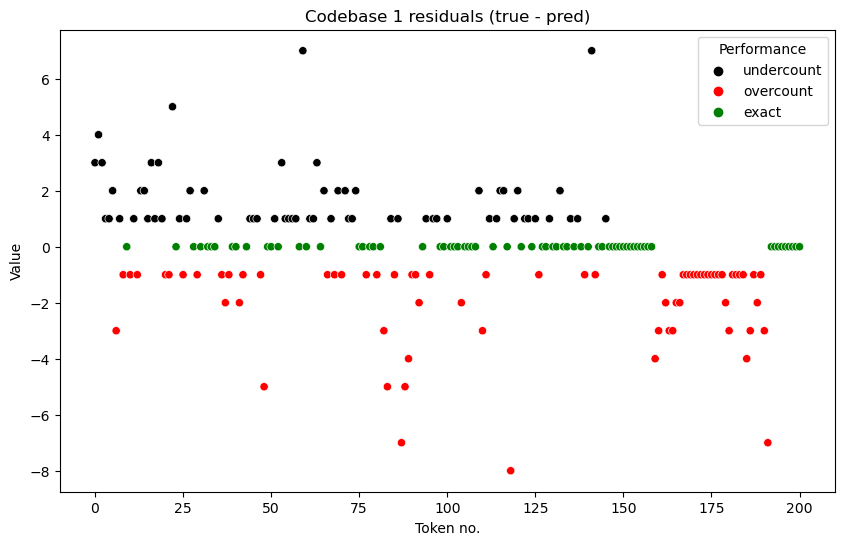

/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated a

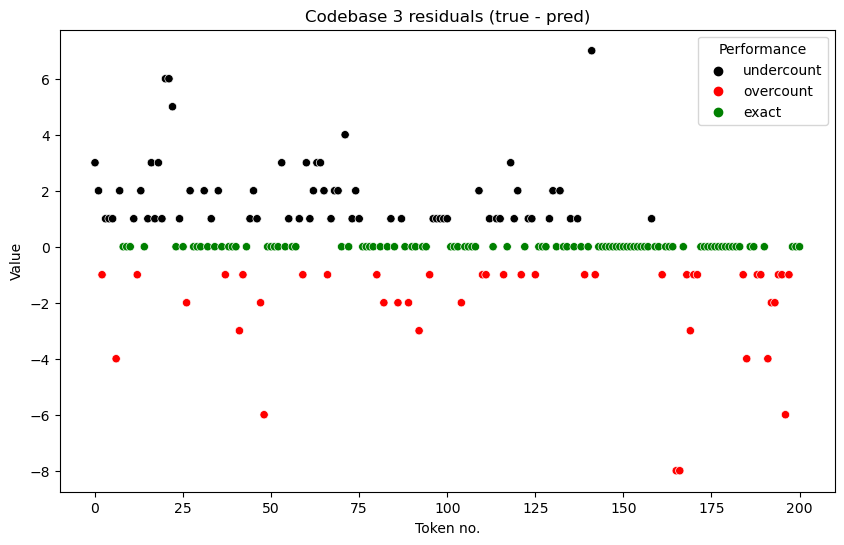

/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated a

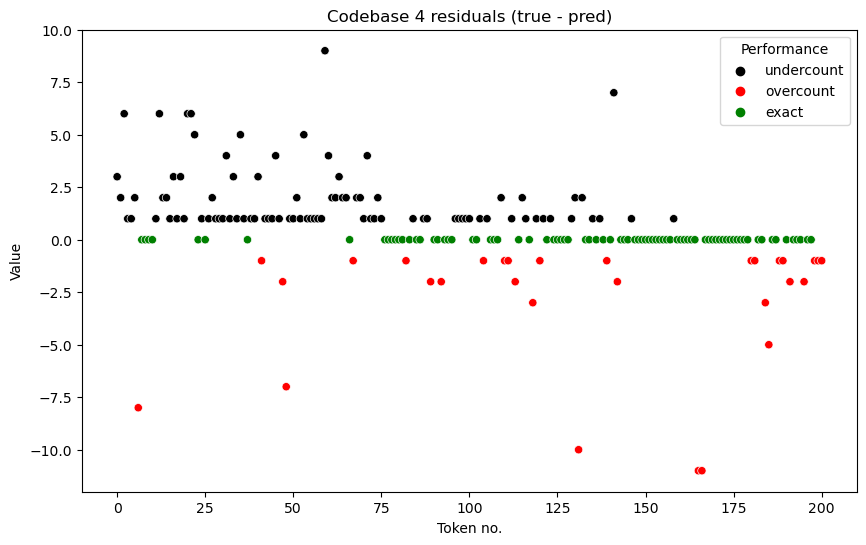

In [74]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
plt.rcdefaults()
plt.figure(figsize=(10, 6)) 
sns.scatterplot(data=merge_step3, x=merge_step3.index, y='count_cb1_residuals', hue = 'status_cb1', palette={'undercount': 'black', 'overcount': 'red', 'exact': 'green'})
plt.xlabel('Token no.')
plt.ylabel('Value')
plt.title('Codebase 1 residuals (true - pred)')
plt.legend(title='Performance')
plt.show()

plt.figure(figsize=(10, 6)) 
sns.scatterplot(data=merge_step3, x=merge_step3.index, y='count_cb3_residuals', hue = 'status_cb3', palette={'undercount': 'black', 'overcount': 'red', 'exact': 'green'})
plt.xlabel('Token no.')
plt.ylabel('Value')
plt.title('Codebase 3 residuals (true - pred)')
plt.legend(title='Performance')
plt.show()

plt.figure(figsize=(10, 6)) 
sns.scatterplot(data=merge_step3, x=merge_step3.index, y='count_cb4_residuals', hue = 'status_cb4', palette={'undercount': 'black', 'overcount': 'red', 'exact': 'green'})
plt.xlabel('Token no.')
plt.ylabel('Value')
plt.title('Codebase 4 residuals (true - pred)')
plt.legend(title='Performance')
plt.show()

/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/cm/shared/openmind8/anaconda/3-2023.09-0/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated a

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

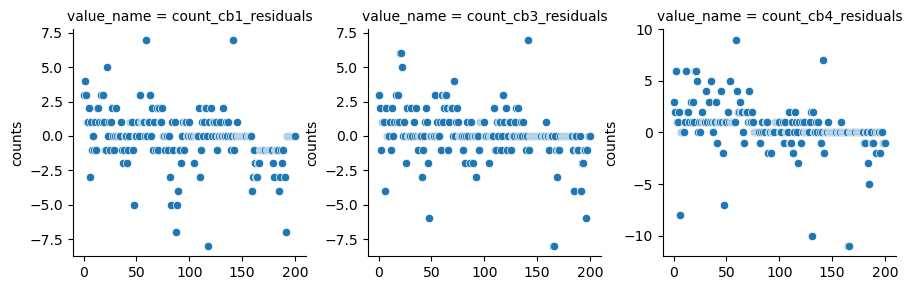

In [81]:
df_long = pd.melt(merge_step3, value_vars=['count_cb1_residuals', 'count_cb3_residuals', 'count_cb4_residuals'],
                  var_name='value_name', value_name='counts')

g = sns.FacetGrid(df_long, col='value_name', col_wrap=3, sharex=False, sharey=False)
g.map_dataframe(sns.scatterplot, x = merge_step3.index,y='counts')

# Add titles and adjust layout
g.set_titles("{col_name}")
g.set_axis_labels("X-axis", "Y-axis")
plt.show()